In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import sys
import datetime
import matplotlib.pyplot as plt
import pyfolio as pf

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar, standard_data_structures as bar
import mlfinlab as ml

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml import sampling, features

/mnt/afml/venv/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [3]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

## Get dollar bar

In [4]:
fname = 'dataset/TRADE_A233740_2018.csv'
bar_fname = 'dataset/DBAR_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
    
if os.path.exists(bar_fname):
    dbar = pd.read_csv(bar_fname, index_col='date_time')
    dbar.index = pd.to_datetime(dbar.index)
else:
    dbar = bar.get_dollar_bars(fname, threshold=1e8)
    dbar.index = pd.to_datetime(dbar.index)
    dbar.to_csv(bar_fname)

In [5]:
print(df.shape)
print(dbar.shape)

(7647271, 5)
(518545, 5)


In [6]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [7]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

In [8]:
df_sub = df[df.index>datetime.datetime(2018,5,23,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,24,9,0)]
dbar_sub = dbar[dbar.index>datetime.datetime(2018,5,23,9,0)]
dbar_sub = dbar_sub[dbar_sub.index<datetime.datetime(2018,5,24,9,0)]

/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


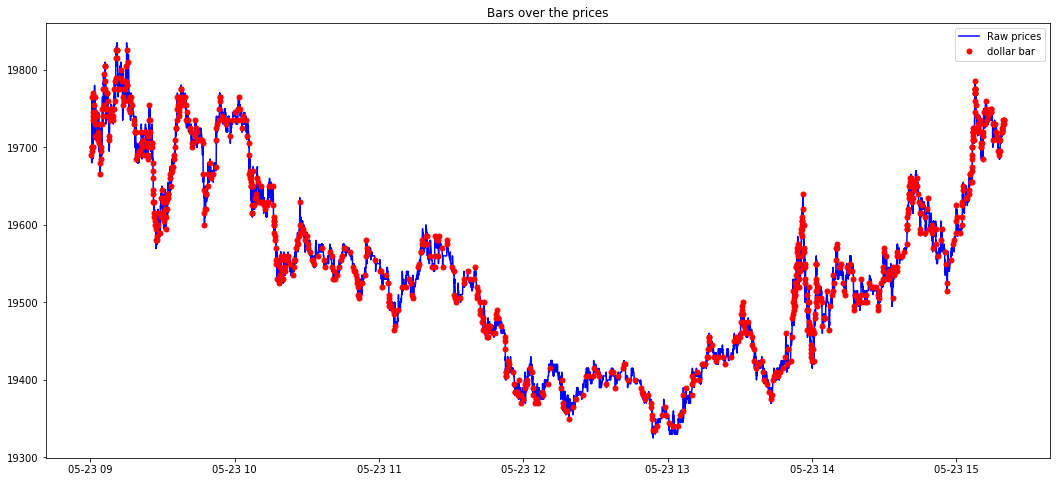

In [ ]:
plot_bars(df_sub, dbar_sub, 'dollar bar')

## Apply triple barrier

In [ ]:
diff = np.log(dbar['close']).diff()

In [ ]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
daily_vol_mean = daily_vol.rolling(10000).mean()
cusum_events = ml.filters.cusum_filter(dbar['close'], daily_vol_mean=daily_vol_mean)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dbar['close'], num_days=1)

Timestamp('2018-01-03 09:00:21.481000')


In [ ]:
print(dbar.shape)
print(cusum_events.shape)
print(vertical_barriers.shape)

(518545, 5)
(28864,)
(28777,)


In [ ]:
dbar.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


## Primary - Build Label

In [ ]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

2019-05-31 18:32:21.395622 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [ ]:
labels_p = ml.labeling.get_bins(triple_barrier_events, dbar['close'])

In [ ]:
labels_p.bin.value_counts()

-1    1727
 1    1679
 0     211
Name: bin, dtype: int64

## Primary - Features

In [ ]:
raw_data = dbar.copy()

In [ ]:
raw_data.head()

,open,high,low,close,volume
date_time,,,,,
2018-01-02 10:00:03.348,19800.0,19980.0,19800.0,19980.0,216028
2018-01-02 10:00:03.349,19980.0,19985.0,19980.0,19985.0,8088
2018-01-02 10:00:04.614,19985.0,19990.0,19980.0,19990.0,6175
2018-01-02 10:00:06.841,19990.0,19995.0,19985.0,19990.0,7656
2018-01-02 10:00:10.929,19990.0,20000.0,19990.0,20000.0,8716


In [ ]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# fracdiff_FFD (Ch.05)
raw_data['fd_ffd'] = features.frac_diff_FFD(raw_data['log_ret'], 0.3, thres=1e-3)

# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Insert seq-bootstrap, sample weight, time decay here

In [ ]:
# Sequential bootstrap
beg_date = dbar.index[0].date()
end_date = dbar.index[-1].date()

cur_bar_date = beg_date
step_day = 14
seq_phi_t1_idx = []
while cur_bar_date < end_date:
    cur_t1_date = cur_bar_date + datetime.timedelta(days=1)
    end_t1_date = cur_t1_date + datetime.timedelta(days=step_day)
    
    print("process {} - {}, total seq {}".format(cur_t1_date, end_t1_date, len(seq_phi_t1_idx)))
    sub_vbar = dbar.loc[cur_bar_date:end_t1_date]
    sub_t1 = triple_barrier_events.loc[cur_bar_date:end_t1_date]
    if len(sub_t1) == 0:
        print("len sub_t1 is zero")
        cur_bar_date += datetime.timedelta(days=step_day)
        continue
    bar_idx, t1 = get_baridx_t1(sub_vbar, sub_t1)
    
    
    ind_m = sampling.get_ind_matrix(bar_idx, t1)
    seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
    
    seq_phi_t1_idx += sub_t1.iloc[seq_phi].sort_index().loc[cur_t1_date:end_t1_date].index
    cur_bar_date += datetime.timedelta(days=step_day)
print(len(seq_phi_t1_idx))

In [ ]:
# sample weight and time decay
from finance_ml.sampling import time_weight, weight
wgt = time_weight.get_sample_weight(np.log(dbar['close']).diff(), triple_barrier_events['t1'], num_co_events)
td = weight.get_time_decay(tw, last_w=0.5)
sample_weight = wgt[seq_phi_t1_idx] * td[seq_phi_t1_idx]

In [ ]:
# Get features at event dates
X = raw_data.loc[seq_phi_t1_idx, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels_p.loc[seq_phi_t1_idx,'bin']

## Primary - Balance classes

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [ ]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

In [ ]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
"""
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()
"""
# class별 blanace 필요

In [ ]:
# Create training data
y_train = train_df['bin']
X_train = train_df.loc[:, train_df.columns != 'bin']

## Primary - Fit a model

In [ ]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, n_jobs=3)
    
    clf.fit(X_data, y_data, fit_params={'sample_weight':sample_weight})
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [ ]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

In [ ]:
# Refit a new model with best params, so we can see feature importance
rf1 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf1.fit(X_train, y_train.values.ravel(), sample_weight)

## Primary - Training metrics

In [ ]:
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_train)[:, 1]
y_pred = rf1.predict(X_train)
x_side = y_pred
#fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

# plt.figure(1)
# plt.plot([-1, 1], [-1, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

## Primary - Validation metrics

In [ ]:
# Meta-label
# Performance Metrics
y_pred_rf = rf1.predict_proba(X_validate)[:, 1]
y_pred = rf1.predict(X_validate)
x_side = np.concatenate([x_side, y_pred])
# fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rf, tpr_rf, label='RF')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf1.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

## Meta Labeling

In [ ]:
dbar.head()

In [ ]:
raw_data = dbar.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# fracdiff_FFD (Ch.05)
raw_data['fd_ffd'] = features.frac_diff_FFD(raw_data['log_ret'], 0.3, thres=1e-3)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [ ]:
raw_data.head()

In [ ]:
X = raw_data

X.dropna(inplace=True)

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [ ]:
total_predict = rf1.predict(X)

In [ ]:
total_predict.shape

In [ ]:
dbar2 = dbar.loc[X.index]

In [ ]:
dbar2['side'] = total_predict

In [ ]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar2['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=dbar2['side'])

In [ ]:
triple_barrier_events.head()

In [ ]:
labels_m = ml.labeling.get_bins(triple_barrier_events, dbar2['close'])
labels_m.side.value_counts()

In [ ]:
labels_m.bin.value_counts()

## Meta - Prepare training data

#### Insert seq-bootstrap, sample weight, time decay here

In [ ]:
# Sequential bootstrap
beg_date = dbar.index[0].date()
end_date = dbar.index[-1].date()

cur_bar_date = beg_date
step_day = 14
seq_phi_t1_idx = []
while cur_bar_date < end_date:
    cur_t1_date = cur_bar_date + datetime.timedelta(days=1)
    end_t1_date = cur_t1_date + datetime.timedelta(days=step_day)
    
    print("process {} - {}, total seq {}".format(cur_t1_date, end_t1_date, len(seq_phi_t1_idx)))
    sub_vbar = dbar.loc[cur_bar_date:end_t1_date]
    sub_t1 = triple_barrier_events.loc[cur_bar_date:end_t1_date]
    if len(sub_t1) == 0:
        print("len sub_t1 is zero")
        cur_bar_date += datetime.timedelta(days=step_day)
        continue
    bar_idx, t1 = get_baridx_t1(sub_vbar, sub_t1)
    
    
    ind_m = sampling.get_ind_matrix(bar_idx, t1)
    seq_phi = sampling.seq_bootstrap(ind_m, verbose=False)
    
    seq_phi_t1_idx += sub_t1.iloc[seq_phi].sort_index().loc[cur_t1_date:end_t1_date].index
    cur_bar_date += datetime.timedelta(days=step_day)
print(len(seq_phi_t1_idx))

In [ ]:
# sample weight and time decay
from finance_ml.sampling import time_weight, weight
wgt = time_weight.get_sample_weight(np.log(dbar['close']).diff(), triple_barrier_events['t1'], num_co_events)
td = weight.get_time_decay(tw, last_w=0.5)
sample_weight = wgt[seq_phi_t1_idx] * td[seq_phi_t1_idx]

In [ ]:
# Get features at event dates
X = raw_data.loc[seq_phi_t1_idx, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

y = labels_m.loc[seq_phi_t1_idx,'bin']

In [ ]:
y.value_counts()

## Meta - Balance classes

In [ ]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [ ]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

In [ ]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

In [ ]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

## Meta - Fit a model

In [ ]:
parameters = {'max_depth':[2, 4],
              'n_estimators':[2, 10],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)    
    clf.fit(X_data, y_data, fit_params={'sample_weight':sample_weight})    
    print(clf.cv_results_['mean_test_score'])    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [ ]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

In [ ]:
# Refit a new model with best params, so we can see feature importance
rf2 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf2.fit(X_train, y_train.values.ravel(), sample_weight)

## Meta - Training Metrics

In [ ]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_train)[:, 1]
y_pred = rf2.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Meta - Validation Metrics

In [ ]:
# Meta-label
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_validate)[:, 1]
y_pred = rf2.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print(X_validate.index.min())
print(X_validate.index.max())

In [ ]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf2.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

## Without Meta Labeling

In [ ]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [ ]:
y_pred = rf1.predict(X_validate)

valid_dates = X_validate.index
labels1 = labels_p.loc[valid_dates].copy()
labels2 = labels_p.loc[valid_dates].copy()
labels1.loc[labels1.loc[valid_dates, 'ret'].loc[y_pred!=1].index,'ret'] = 0
labels2.loc[labels2.loc[valid_dates, 'ret'].loc[y_pred!=-1].index,'ret'] = 0
primary_rets = labels1['ret'] - labels2['ret']
primary_model_rets = get_daily_returns(primary_rets)

In [ ]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [ ]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)

### With Meta Labeling

In [ ]:
y_pred = rf2.predict(X_validate)
meta_returns = primary_rets * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [ ]:
# Save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

pf.show_perf_stats(daily_meta_rets)

---
## Perform out-of-sample test
### Meta Model Metrics

In [ ]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2018-11-01':]
y_oos = y['2018-11-01':]
labels_oos = labels_m['2018-11-01':]

In [ ]:
# Primary model
y_pred_rf = rf1.predict_proba(X_oos)[:, 1]
y_pred = rf1.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([-1, 1], [-1, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Performance Metrics
y_pred_rf = rf2.predict_proba(X_oos)[:, 1]
y_pred = rf2.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Primary Model (Test Data)

In [ ]:
test_dates = X_oos.index

# Downsample to daily
y_pred = rf1.predict(X_oos)
labels1 = labels_oos.copy()
labels2 = labels_oos.copy()
labels1.loc[labels1.loc[test_dates, 'ret'].loc[y_pred!=1].index,'ret'] = 0
labels2.loc[labels2.loc[test_dates, 'ret'].loc[y_pred!=-1].index,'ret'] = 0
primary_rets = labels1['ret'] - labels2['ret']
daily_rets_prim = get_daily_returns(primary_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=daily_rets_prim, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(daily_rets_prim)

## Meta Model (Test Data)

In [ ]:
y_pred = rf2.predict(X_oos)
meta_returns = primary_rets * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)